# Deep Neural Network Model - Hiperparameters Tuning

Input: testing different number of months in input using single PCA

Output: optimal max-shape portfolio with tight restrictions for the next period

In [1]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.regularizers import L2
from keras.optimizers import Adam

from sklearn.model_selection import StratifiedKFold
import keras_tuner

from helper_functions import train_and_evaluate_model, calculate_returns_for_model, daily_to_annual_returns

In [2]:
import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [ ]:
data_provider = DataProvider()
y = data_provider.get_formatted_targets()

## Cross validation to calculate optimal number of months

In [3]:
df_countries, _ = data_provider.get_etf_data()
days_to_recalculate = data_provider.get_days_to_recalculate()

val_split = int(0.7 * y.shape[0])
test_split = int(0.8 * y.shape[0])
dates_for_validation = days_to_recalculate[val_split:test_split]

df_prices_val = df_countries[dates_for_validation[0]:]
df_returns_val = np.log(df_prices_val).diff().fillna(0)

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [4]:
max_sharpe = 0
best_month_no = 0

for no_months in range(3, 10):
    print(f'DNN Model for {no_months} months')
    x = data_provider.get_formatted_features(no_months=no_months)
    x_train, y_train, x_val, y_val, x_test, y_test = data_provider.train_train_split(x, y)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    skf.get_n_splits(x_train, y_train)

    sum_sharpe = 0
    for _, (train_index, val_index) in enumerate(skf.split(x_train, np.zeros(y_train.shape[0]))):
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]
        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        model = Sequential((
            Flatten(input_shape=x_train.shape[1:]),
            Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
            Dense(y_train.shape[1], activation='softmax')
        ))
        model.compile(optimizer=Adam(learning_rate=1e-3),
                      loss='mean_squared_error')
        _ = model.fit(x_train_fold, y_train_fold,
                      validation_data=(x_val_fold, y_val_fold),
                      epochs=200, verbose=False)

        total_ret_val, _ = calculate_returns_for_model(model, x_val, dates_for_validation, df_returns_val)

        annual_returns = daily_to_annual_returns(total_ret_val)
        annual_volatility = total_ret_val.std()*np.sqrt(252)
        annual_sharpe_val = annual_returns/annual_volatility
        sum_sharpe += annual_sharpe_val
        print('Sharpe fold', annual_sharpe_val)

    mean_sharpe_val = sum_sharpe/5
    print('Mean Sharpe', mean_sharpe_val)
    if mean_sharpe_val > max_sharpe:
        max_sharpe = mean_sharpe_val
        best_month_no = no_months

print('Best number of months', best_month_no, 'with mean Sharpe ratio', max_sharpe)

DNN Model for 3 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sharpe fold 0.3977846672979762
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sharpe fold 0.39636110485211046
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sharpe fold 0.3925878025676184
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Sharpe fold 0.38003113201050565
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Sharpe fold 0.37041246949164996
Mean Sharpe 0.3874354352439721
DNN Model for 4 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Sharpe fold 0.3970832271358688
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Sharpe fold 0.42170443563048127
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sharpe fold 0.40474286331361126
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Sharpe fold 0.38947388006567774
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Sharpe fold 0.388115707115688
Mean Sharpe 0.40022402265226537
DNN Model for 5 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sharpe fold 0.4058127979564952
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sharpe fold 0.41074804222586253
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Sharpe fold 0.4136312330047446
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Sharpe fold 0.382333333502168
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sharpe fold 0.4043471118391798
Mean Sharpe 0.40337450370569006
DNN Model for 6 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Sharpe fold 0.4078475050319654
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sharpe fold 0.4206766073752545
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Sharpe fold 0.39892476638518193
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sharpe fold 0.38675245643545253
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sharpe fold 0.4200625954817308
Mean Sharpe 0.406852786141917
DNN Model for 7 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sharpe fold 0.4120794675964662
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sharpe fold 0.4147501621900109
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Sharpe fold 0.4132433058490528
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sharpe fold 0.41391090778755296
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Sharpe fold 0.3963201755805378
Mean Sharpe 0.4100608038007241
DNN Model for 8 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Sharpe fold 0.4143757229100126
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sharpe fold 0.3975997778779259
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sharpe fold 0.39637496074199713
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sharpe fold 0.387015244218168
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Sharpe fold 0.40455426424671653
Mean Sharpe 0.39998399399896406
DNN Model for 9 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Sharpe fold 0.4049257770265251
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sharpe fold 0.4015306151682698
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sharpe fold 0.40535199824773116
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Sharpe fold 0.397644413450852
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sharpe fold 0.40676195721707986
Mean Sharpe 0.4032429522220916
Best number of months 7 with mean Sharpe ratio 0.4100608038007241


In [5]:
# best_month_no = 6

x = data_provider.get_formatted_features(no_months=best_month_no)
x_train, y_train, x_val, y_val, x_test, y_test = data_provider.train_train_split(x, y)

## Hiperparameters Tuning

In [6]:
def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=x_train.shape[1:]))
    model.add(Dense(hp.Choice('units', [64, 128, 256]),
              activation='relu', 
              kernel_regularizer=L2(hp.Choice('reg', [0.0, 0.1]))))
    
    if hp.Boolean("second_layer"):
        model.add(Dense(hp.Choice('units2', [64, 128, 256]),
              activation='relu', 
              kernel_regularizer=L2(hp.Choice('reg2', [0.0, 0.1])))),
    
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(loss='mse')
    return model

In [7]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=100,
    directory='tuning',
    project_name='model_dnn')

Reloading Tuner from tuning\model_dnn\tuner0.json


In [8]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
units (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}
reg (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.1], 'ordered': True}
second_layer (Boolean)
{'default': False, 'conditions': []}
units2 (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}
reg2 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.1], 'ordered': True}


In [9]:
tuner.search(x_train, y_train, epochs=100, validation_data=(x_val, y_val))

In [14]:
tuner.results_summary()

Results summary
Results in tuning\model_dnn
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 018 summary
Hyperparameters:
units: 256
reg: 0.0
second_layer: True
units2: 256
reg2: 0.0
Score: 0.00046792771900072694

Trial 006 summary
Hyperparameters:
units: 64
reg: 0.0
second_layer: True
units2: 128
reg2: 0.0
Score: 0.0004971480229869485

Trial 011 summary
Hyperparameters:
units: 256
reg: 0.0
second_layer: True
units2: 64
reg2: 0.0
Score: 0.0005026614526286721

Trial 008 summary
Hyperparameters:
units: 128
reg: 0.0
second_layer: True
units2: 256
reg2: 0.0
Score: 0.0005133777158334851

Trial 004 summary
Hyperparameters:
units: 256
reg: 0.0
second_layer: True
units2: 128
reg2: 0.0
Score: 0.0005156720872037113

Trial 055 summary
Hyperparameters:
units: 64
reg: 0.0
second_layer: True
units2: 64
reg2: 0.0
Score: 0.000520567933563143

Trial 062 summary
Hyperparameters:
units: 256
reg: 0.0
second_layer: False
units2: 64
reg2: 0.1
Score: 0.000532745267264545

Trial 050 s

In [18]:
# best_model = tuner.get_best_models()[0]

best_model = Sequential((
    Flatten(input_shape=x_train.shape[1:]),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
))

## Best Model training

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 189)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        48,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 27)             │         6,939 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,371 (474.11 KB)

 Trainable params: 121,371 (474.11 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0069 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - val_loss: 8.8151e-04 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011 - val_loss: 8.0578e-04 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.9793e-04 - val_loss: 7.5058e-04 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.3776e-04 - val_loss: 8.0941e-04 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.5586e-04 - val_loss: 6.3409e-04 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.5335e-04 - val_loss: 5.2054e-04 - learning_rate: 0.

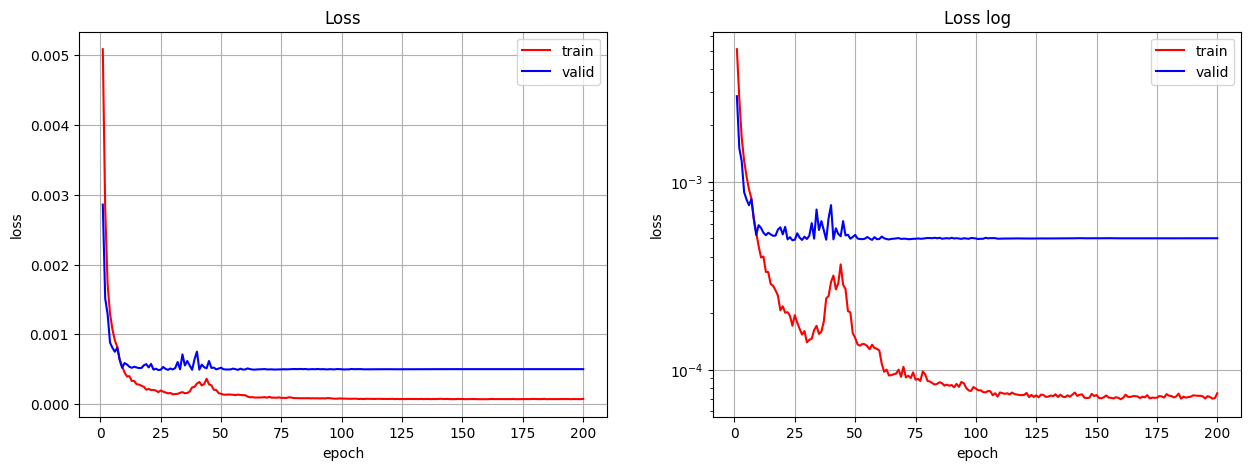

In [19]:
train_and_evaluate_model(best_model, x_train, y_train,
                         x_val, y_val, x_test, y_test)

## Backtesting

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


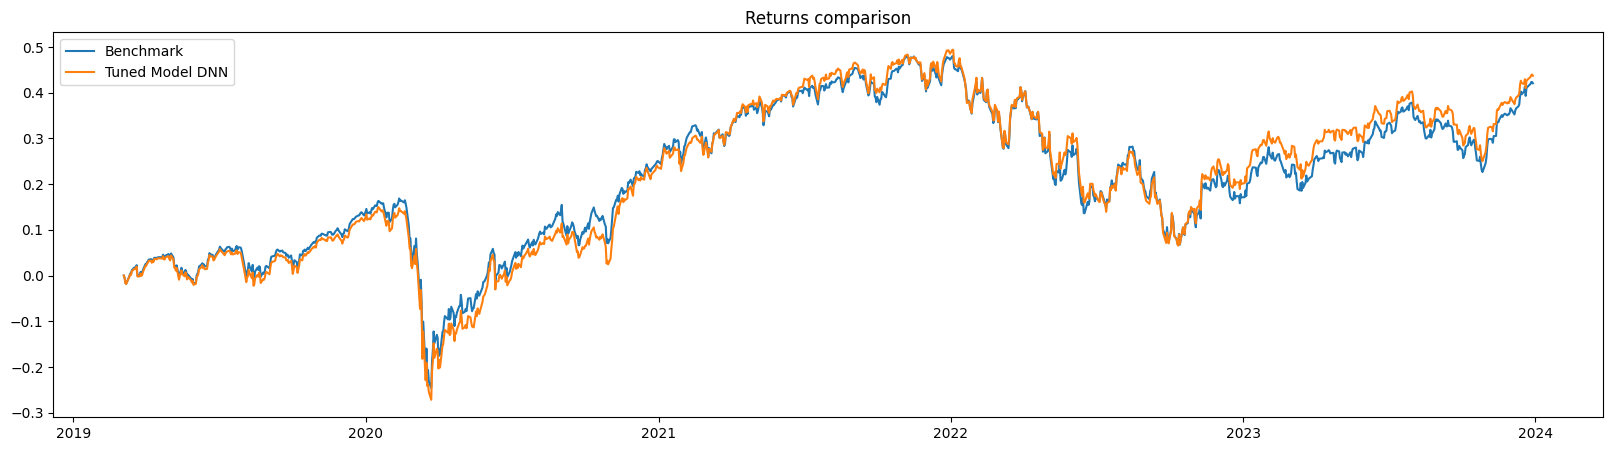

,Annual Returns,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Max Time Under Water,Calmar Ratio,Information Ratio
Benchmark,0.076754,0.203326,0.377494,0.442047,-0.354829,500.0,0.216313,0
Tuned Model DNN,0.078166,0.203616,0.383889,0.448188,-0.366555,500.0,0.213244,0.040254


In [20]:
from helper_functions import run_full_backtesting

models = {'Tuned Model DNN': best_model}
df_results = run_full_backtesting(data_provider, x_test, models)
df_results